In [70]:
import cvxpy as cp
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt

# Control with moment/stochastic relaxation for non-convex constraints

In this notebook, we study the control problem
$$
\begin{align}
	\mathrm{minimize}_{(\mathbb{P}_k^u)} ~&~ \mathbb{E} \sum_{k=0}^N \begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix}^\top R_k
	\begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix} \label{eq:timeVaryingProblem1}\\
	\mathrm{s.t.} ~&~ x_{k+1} = f_k + A_k x_k + B_k u_k + w_k\\
	~&~ \mathbb{E} \begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix}^\top H_{ki}
	\begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix} \leq 0 \quad i = 1,\ldots,s \label{eq:timeVaryingProblem3}\\
    ~&~ u_k \sim \mathbb{P}_k^u(x_k)\\
    ~&~ w_k \sim \mathbb{P}_k^w\\
	~&~ x_0 \sim \mathbb{P}_0^x.
\end{align}
$$
In this control problem, $A_k \in \mathbb{R}^{n\times n}$ and $B_k \in \mathbb{R}^{n\times m}$ are time-varying system matrices of a linear dynamical system with an additional affine term $f_k$. Accordingly, we interprete the variable $x_k$ as the state, $u_k$ as a control input and $w_k$ as a disturbance input. The variables $x_0$ and $w_k$ for $k = 0,\ldots,N-1$ are distributed according to the random distributions $\mathbb{P}_0^x$ and $\mathbb{P}_k^w$ for $k = 0,\ldots,N-1$. These distributions are assumed to be independent. The disturbance distributions are additionally assumed to be zero mean. The control input $u_k$ is assumed to be distributed according to the random distribution $\mathbb{P}_k^u(x_k)$, which, given $x_k$ is conditionally independent from all other random distributions. Due to these random distributions, the states $x_k$, inputs $u_k$ and disturbances $w_k$ are all random variables. The distributions $\mathbb{P}_k^u(x_k)$ are interpreted as control policies and, therefore, they are the decision variables of this dynamic program. Finally, $H_{ki}$ and $R_k$ for $k = 0,\ldots,N$ and $i = 1,\ldots,s$ are assumed to be possibly indefinite symmetric matrices.

Because $H_{ki}$ and $R_k$ are indefinite, this optimization problem could not be easily convexified if we would consider it as a deterministic dynamic program. As a stochastic dynamic program, however, this dynamic program is equivalent to the semi-definite program
$$
\begin{align}
	\mathrm{minimize}_{(\Sigma_k)} ~&~ \sum_{k=0}^N \mathrm{trace} \Sigma_k R_k \label{eq:timeVaryingSynthesis}\\
	\mathrm{s.t.} ~&~ \sigma_k^{11} = 1 & k = 0,\ldots,N \nonumber\\
	~&~ \widetilde{F}(\Sigma_k,\Sigma_{k+1},\Sigma_k^w) = 0 & k = 0,\ldots,N-1 \nonumber\\
	~&~ \mathrm{trace} \Sigma_k H_{ki} \leq 0 & k = 0,\ldots, N, i = 1,\ldots,s\nonumber\\
	~&~ \Sigma_k \succeq 0 & k = 0,\ldots,N. \nonumber
\end{align}
$$
In this semi-definite program the decision variables, i.e., the matrices
$$
\begin{align}
	\Sigma_k =
	\begin{pmatrix}
		\sigma_k^{11} & \sigma_k^{12} & \sigma_k^{13}\\
		\sigma_k^{21} & \Sigma_k^{22} & \Sigma_k^{23}\\
		\sigma_k^{31} & \Sigma_k^{32} & \Sigma_k^{33}
	\end{pmatrix}
	:=
	\mathbb{E} \begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix}
	\begin{pmatrix}
		1\\
		x_k\\
		u_k
	\end{pmatrix}^\top . \label{eq:momentEquation}
\end{align}
$$
Those are the moment matrices of the state $x_k$ and the input $u_k$. The moment matrices
$$
\begin{align}
	\begin{pmatrix}
		\bar{\sigma}_0^{11} & \bar{\sigma}_0^{12}\\
		\bar{\sigma}_0^{21} & \overline{\Sigma}_0^{22}
	\end{pmatrix}
	:=
	\mathbb{E} \begin{pmatrix}
		1\\
		x_0
	\end{pmatrix}
	\begin{pmatrix}
		1\\
		x_0
	\end{pmatrix}^\top && \text{and} && \Sigma^w_k = \mathbb{E} w_k w_k^\top
\end{align}
$$
of the initial state and the disturbances are assumed to be fixed and known. If an optimal solution to this semi-definite program in the form of a sequence of moment matrices can be obtained, then this enables the extraction of an optimal policy $\mathbb{P}_k^u(x_k)$. This policy can be expressed by defining the random variable $u_k$ as
$$
\begin{align}
		u_k &= \begin{pmatrix}
			\sigma_k^{31} & \Sigma_k^{32}
		\end{pmatrix}
		\begin{pmatrix}
			\sigma_k^{11} & \sigma_k^{12}\\
			\sigma_k^{21} & \Sigma_k^{22}
		\end{pmatrix}^{-1}
		\begin{pmatrix}
			1\\ x_k
		\end{pmatrix} + v_k & v_k \sim \mathbb{P}_k^v, \label{eq:controllerReconstruction}
	\end{align}
$$
where $\mathbb{P}_k^v$ is the distribution of some random variable $v_k$, which is zero mean, has the second moment
$$
\begin{align}
		\Sigma_k^v := \Sigma_k^{33} - \begin{pmatrix}
			\sigma_k^{31} & \Sigma_k^{32}
		\end{pmatrix}
		\begin{pmatrix}
			\sigma_k^{11} & \sigma_k^{12}\\
			\sigma_k^{21} & \Sigma_k^{22}
		\end{pmatrix}^{-1} \begin{pmatrix}
			\sigma_k^{13}\\
			\Sigma_k^{23}
		\end{pmatrix}
	\end{align}
$$
and is stochastically independent from $x_0$ and $w_k$ for $k = 0,\ldots, N-1$.


In this notebook we present two elementary examples for this controller design strategy. We start by defining a function that computes the optimal policy $(\mathbb{P}_k^u)$ using cvxpy and Mosek.

In [71]:
def finite_horizon_stateSpace(Xbar,f,A,B,R,H,SigmaW):
    # Extract problem dimensions
    (n,m) = B[0].shape
    N = len(f)-1
    s = len(H[0])
    
    # Define the decision variables
    nu = 0
    Sigmaxu = cp.Variable((1+n,m))
    Sigmauu = cp.Variable((m,m),symmetric = True)
    Sigma = cp.bmat([[Xbar,Sigmaxu],
                     [Sigmaxu.T,Sigmauu]])
    S = [Sigma]
    constraints = [Sigma >> 0]
    
    # Constraint (1)
    for k in range(N):
        temp = np.block([[np.ones((1,1)), np.zeros((1,n+m))],
                         [f[k],A[k],B[k]]])
        Sigmaxx = temp@S[k]@temp.T + np.block([[np.zeros((1,1+n))],[np.zeros((n,1)),SigmaW[k]]])
        Sigmaxu = cp.Variable((1+n,m))
        Sigmauu = cp.Variable((m,m),symmetric = True)
        Sigma = cp.bmat([[Sigmaxx,Sigmaxu],
                         [Sigmaxu.T,Sigmauu]])
        S += [Sigma]
        constraints += [Sigma >> 0]
    # Constraint (2)
    for k in range(N+1):
        for i in range(s):
            constraints += [cp.trace(S[k]@H[k][i]) <= 0]
    
    # Constraint (3)
    constraints += [S[0][0:1+n,0:1+n] == Xbar]
    
    # Constraint (4)
    for k in range(N+1):
        nu += cp.trace(S[k]@R[k])
    
    # Call the solver
    prob = cp.Problem(cp.Minimize(nu),constraints)
    solver_options = {'MSK_DPAR_INTPNT_CO_TOL_PFEAS': 1e-08,
                          'MSK_DPAR_INTPNT_TOL_DFEAS': 1e-08,
                          'MSK_DPAR_INTPNT_CO_TOL_INFEAS': 1e-10,
                          'MSK_DPAR_INTPNT_CO_TOL_MU_RED': 1e-10,
                          'MSK_DPAR_INTPNT_CO_TOL_REL_GAP': 1e-10,
                          'MSK_DPAR_INTPNT_TOL_INFEAS': 1e-8,
                          }
    prob.solve(solver = "MOSEK",verbose = True) #,mosek_params = solver_options
    # Reconstruct the controller
    #K = [S[k][1+n:1+n+m,0:1+n].value @ np.linalg.pinv(S[k][0:1+n,0:1+n].value) for k in range(N + 1)]
    K = [np.linalg.solve(S[k][0:1+n,0:1+n].value + (1e-5)*np.identity(1+n),S[k][0:1+n,1+n:1+n+m].value).T for k in range(N + 1)]
    SigmaV = [S[k][1+n:1+n+m,1+n:1+n+m].value - S[k][1+n:1+n+m,0:1+n].value @ K[k].T for k in range(N+1)]
    nu = nu.value
    Sigma = [Sig.value for Sig in S]
    return (K,SigmaV,nu,Sigma)

## Example 1

Next, we study a first example which is motivated by obstacle avoidance. To this end, we consider the extremely simplified dynamics of a robot given by
$$
\begin{align}
	x_{t +1} &= x_t + u_t & x_t,u_t \in \mathbb{R}^2.
\end{align}
$$
These are the equations of motions of two parallel integrators modelling the dynamics of the robot as an integrator in $x_1$ and another integrator in $x_2$ direction. To make sure that the robot cannot take arbitrarily large steps, we introduce the first constraint
$$
\begin{align}
    \mathbb{E} u_t^2 &\leq 1 &\Leftrightarrow && \mathrm{trace} \Sigma_t H_{t1} \leq 0 \text{   for   } H_{t1} = \begin{pmatrix} -0.1 & 0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0 & 0\\
    0 & 0 & 0 & 0 & 0\\
    0 & 0 & 0 & 1 & 0\\
    0 & 0 & 0 & 0 & 1
    \end{pmatrix}.
\end{align}
$$
The task of the robot is to reach a target position of $\begin{pmatrix}
	0 & 0
\end{pmatrix}^\top$ from the starting position $\bar{x} = \begin{pmatrix}
	10 & 0
\end{pmatrix}^\top$. We express the starting position with the moment matrix of the dirac distribution
$$
\begin{align}
	\begin{pmatrix}
		\bar{\sigma}_0^{11} & \bar{\sigma}_0^{12}\\
		\bar{\sigma}_0^{21} & \overline{\Sigma}_0^{22}
	\end{pmatrix}
	=
	\begin{pmatrix}
		1 & \bar{x}^\top\\
		\bar{x} & \bar{x}\bar{x}^\top
	\end{pmatrix}
\end{align}
$$
and incorporate the target position in the cost function, which we choose as
$$
\begin{align}
\mathrm{trace} \Sigma_t R_t && \text{with} && R_t = 
    \begin{pmatrix}
    0 & 0 & 0 & 0 & 0\\
    0 & 1 & 0 & 0 & 0\\
    0 & 0 & 1 & 0 & 0\\
    0 & 0 & 0 & 1 & 0\\
    0 & 0 & 0 & 0 & 1
    \end{pmatrix}.
\end{align}
$$
To make the task of the robot interesting, we assume circular objects in the path of the robot. Particularly, we assume there to be two obstacles with radius one at the positions
$$
\begin{align}
	\begin{pmatrix}
		\hat{x}_{11}\\
		\hat{x}_{12}
	\end{pmatrix}
	&=
	\begin{pmatrix}
		-7.5\\
		0.5
	\end{pmatrix},
	&
	\begin{pmatrix}
		\hat{x}_{21}\\
		\hat{x}_{22}
	\end{pmatrix}
	&=
	\begin{pmatrix}
		-2.5\\
		-0.5
	\end{pmatrix}.
\end{align}
$$
The constraint to avoid these obstacles (in expectation) can be formulated as
$$
\begin{align}
    \mathbb{E} ((r_i + \varepsilon_i)^2 - \|\hat{x}_i - x_t\|^2) \leq 0 && \Leftrightarrow && \mathrm{trace} \Sigma_t H_{ti} \leq  0 ~~~ \mathrm{for}~~~
    H_{ti} =
    \begin{pmatrix}
        (r_i + \varepsilon_i)^2 - \|\hat{x}_i\|^2 & \hat{x}_1 & \hat{x}_2 & 0 & 0\\
        \hat{x}_1 & -1 & 0 & 0 & 0\\
        \hat{x}_2 & 0 & -1 & 0 & 0\\
        0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0
    \end{pmatrix}.
\end{align}
$$
The parameters for this control problem are generated by the following code. Obviously, for the considered case, the radius $r_i$ of the obstacles is $r_i = 1$. Notice that we introduced the parameter $\varepsilon_i$ to make the distance to the obstacles larger than zero. In the following, we choose $\varepsilon = 0.1$.

In [72]:
# supply function for initialization
n = 2
m = 2
N = 50

def initParameters1(N):
    R_k = np.zeros((1+n+m,1+n+m))
    for i in range(1,5): R_k[i,i] = 1
    R_N = np.zeros((1+n+m,1+n+m))
    R_N[1,1] = 1
    R_N[2,2] = 1
    Hu = np.zeros((1+n+m,1+n+m))
    Hu[0,0] = -0.1
    Hu[3,3] = 1
    Hu[4,4] = 1
    x_o = [np.array([[-2.5],[-0.5]]),np.array([[-7.5],[0.5]])]
    r = 1.1 # radius is 1.1 and not 1.0 to make obstacle avoidance more clear
    f = [np.zeros((2,1)) for k in range(N+1)]
    A = [np.array([[1,0],[0,1]]) for k in range(N+1)]
    B = [np.array([[1,0],[0,1]]) for k in range(N+1)]
    R = [R_k for k in range(N)] + [R_N]
    H = [[np.block([[-x.T @ x + r**2,x.T,np.zeros((1,m))],
                    [x,-np.identity(n),np.zeros((n,m))],
                    [np.zeros((m,1+n+m))]]) for x in x_o] + [Hu] for k in range(N+1)]
    SigmaW = [0.00*np.identity(n)] + [0.00*np.identity(n) for k in range(N)]
    return (f,A,B,R,H,SigmaW,x_o)

Let us solve the controller design problem for the example detailed above.

In [73]:
xbar = np.array([[1],[-10],[0]])
Xbar = xbar@xbar.T + np.block([[np.zeros((1,1+n))],[np.zeros((n,1)),0.000001*np.identity(n)]])

f,A,B,R,H,SigmaW,x_o = initParameters1(N)

K,SigmaV,nu,Sigma = finite_horizon_stateSpace(Xbar,f,A,B,R,H,SigmaW)

print("The optimal value of the controller design problem is {}".format(nu))

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Mar 08 03:15:53 PM: Your problem has 510 variables, 205 constraints, and 0 parameters.
(CVXPY) Mar 08 03:15:53 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 08 03:15:53 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 08 03:15:53 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 08 03:15:53 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 08 03:15:53 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

(CVXPY) Mar 08 03:16:00 PM: Optimal value: 1.140e+03
(CVXPY) Mar 08 03:16:00 PM: Compilation took 7.080e+00 seconds
(CVXPY) Mar 08 03:16:00 PM: Solver (including time spent in interface) took 4.468e-01 seconds
The optimal value of the controller design problem is 1139.7532758915506


We simulate the controller and plot some trajectories. Notice that we also implement the random component of the controller.

In [74]:
# array for trajectories
x_array = []
u_array = []

num_traj = 10
np.random.seed(6)

for i in range(num_traj):
    x = np.zeros((n,N+1))
    u = np.zeros((m,N))
    x[:,0] = xbar[1:,0]
    for t in range(N):
        if np.trace(SigmaV[t]) > 0.0000001:
            [ew,ev] = np.linalg.eig(SigmaV[t])
            v = np.random.choice([-1,1],size = (n,1))
            v = ev@np.sqrt(ew)@v
        else:
            v = np.zeros((n,1))
        u[:,t:t+1] = K[t]@np.vstack([np.ones((1,1)),x[:,t:t+1]]) + v
        x[:,t+1] = A[t]@x[:,t] + B[t]@u[:,t]
    x_array += [x]
    u_array += [u]

C:\Users\Deniss Grammel\AppData\Local\Temp\ipykernel_20652\2451411569.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


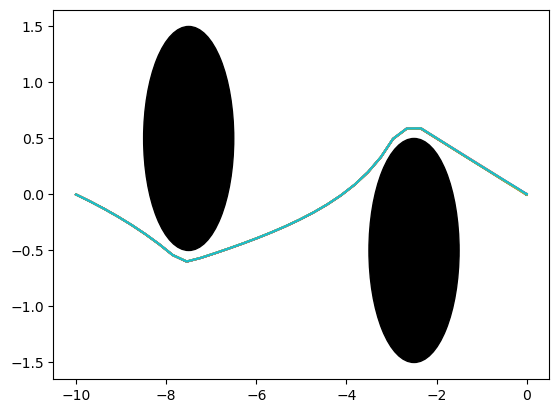

In [75]:
fig, ax = plt.subplots()
for i in range(num_traj):
    x = x_array[i]
    ax.plot(x[0,:],x[1,:])
circles = [plt.Circle(x,1,color = 'k') for x in x_o]
for circle in circles:
    ax.add_patch(circle)
fig.show()

As we see, the trajectories are all the same, i.e., there is no variance in the trajectories. Indeed, this example produces a deterministic controller as optimal policy. We could call this a lucky case, since this implies that also the constraints are deterministically satisfied.

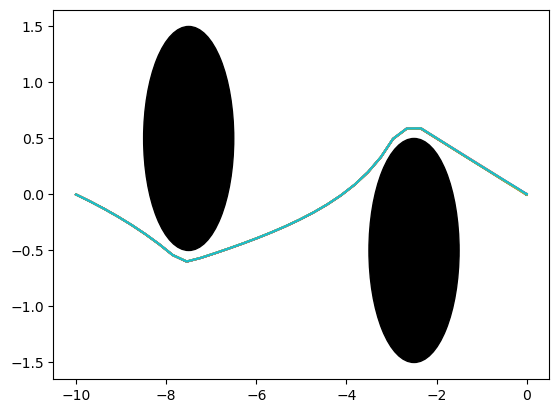

In [76]:
import tikzplotlib
fig, ax = plt.subplots()
for i in range(num_traj):
    x = x_array[i]
    ax.plot(x[0,:],x[1,:])
circle1 = plt.Circle([-7.5,0.5],1,color = 'k')
circle2 = plt.Circle([-2.5,-0.5],1,color = 'k')
ax.add_patch(circle1)
ax.add_patch(circle2)
#fig.show()
tikzplotlib.save("avoidance.tex")

## Example 2

Not all control problems are as lucky as our first example, in the sense that the synthesis problem presented here results in a deterministic solution and the constraints are deterministically satisfied. A first example of a stochastic solution is presented here.

To generate this stochastic solution, we simply change the position of the obstacles from Example 1. In particular, we consider a single obstacle directly in the middle between the robot and the target, i.e,
$$
\begin{align}
	\begin{pmatrix}
		\hat{x}_{11}\\
		\hat{x}_{12}
	\end{pmatrix}
	&=
	\begin{pmatrix}
		-5.0\\
		0.0
	\end{pmatrix}.
\end{align}
$$
This constraint is implemented as in Example 1 with a radius of $r_1 = 1$ and a margin parameter of $\varepsilon = 0.1$.

The next function returns the parameters for this problem

In [77]:
# supply function for initialization
n = 2
m = 2
N = 50

def initParameters2(N):
    R_k = np.zeros((1+n+m,1+n+m))
    for i in range(1,5): R_k[i,i] = 1
    R_N = np.zeros((1+n+m,1+n+m))
    R_N[1,1] = 1
    R_N[2,2] = 1
    Hu = np.zeros((1+n+m,1+n+m))
    Hu[0,0] = -0.1
    Hu[3,3] = 1
    Hu[4,4] = 1
    x_o = [np.array([[-5],[0]])]
    r = 1.1
    f = [np.zeros((2,1)) for k in range(N+1)]
    A = [np.array([[1,0],[0,1]]) for k in range(N+1)]
    B = [np.array([[1,0],[0,1]]) for k in range(N+1)]
    R = [R_k for k in range(N)] + [R_N]
    #x = x_o[0]
    #print(np.block([[-x.T @ x + r**2,x.T,np.zeros((1,m))]]))
    H = [[np.block([[-x.T @ x + r**2,x.T,np.zeros((1,m))],
                    [x,-np.identity(n),np.zeros((n,m))],
                    [np.zeros((m,1+n+m))]]) for x in x_o] + [Hu] for k in range(N+1)]
    SigmaW = [0.00*np.identity(n)] + [0.00*np.identity(n) for k in range(N)]
    return (f,A,B,R,H,SigmaW,x_o)

Again, we solve the problems and plot some trajectories.

In [78]:
xbar = np.array([[1],[-10],[0]])
Xbar = xbar@xbar.T + np.block([[np.zeros((1,1+n))],[np.zeros((n,1)),0.000001*np.identity(n)]])

f,A,B,R,H,SigmaW,x_o = initParameters2(N)

K,SigmaV,nu,Sigma = finite_horizon_stateSpace(Xbar,f,A,B,R,H,SigmaW)

print("The optimal value of the controller design problem is {}".format(nu))

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Mar 08 03:16:29 PM: Your problem has 510 variables, 154 constraints, and 0 parameters.
(CVXPY) Mar 08 03:16:29 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 08 03:16:29 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 08 03:16:29 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 08 03:16:30 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 08 03:16:30 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

(CVXPY) Mar 08 03:16:36 PM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Mar 08 03:16:36 PM:   Solution status : OPTIMAL
(CVXPY) Mar 08 03:16:36 PM:   Primal.  obj: -3.9575283050e+03   nrm: 9e+05    Viol.
(CVXPY) Mar 08 03:16:36 PM:   con: 5e-06  
(CVXPY) Mar 08 03:16:36 PM:   var: 0e+00  
(CVXPY) Mar 08 03:16:36 PM:   barvar: 0e+00  
(CVXPY) Mar 08 03:16:36 PM: 
(CVXPY) Mar 08 03:16:36 PM:   Dual.    obj: -3.9575282670e+03   nrm: 1e+02    Viol.
(CVXPY) Mar 08 03:16:36 PM:   con: 0e+00  
(CVXPY) Mar 08 03:16:36 PM:   var: 3e-07  
(CVXPY) Mar 08 03:16:36 PM:   barvar: 1e-08  
(CVXPY) Mar 08 03:16:36 PM: 
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Mar 08 03:16:36 PM: Problem status: optimal
(CVXPY) Mar 08 03:16:36 PM: Optimal value: 1.142e+03
(CVXPY) Mar 08 03:16:36 PM: Compilat

In [81]:
# array for trajectories
x_array = []
u_array = []

num_traj = 10
np.random.seed(5)

for i in range(num_traj):
    x = np.zeros((n,N+1))
    u = np.zeros((m,N))
    x[:,0] = xbar[1:,0]
    for t in range(N):
        if np.trace(SigmaV[t]) > 0.0000001:
            [ew,ev] = np.linalg.eig(SigmaV[t])
            v = np.random.choice([-1,1],size = (n,1))
            v = ev@np.sqrt(ew)@v
        else:
            v = np.zeros((n,1))
        u[:,t:t+1] = K[t]@np.vstack([np.ones((1,1)),x[:,t:t+1]]) + v
        x[:,t+1] = A[t]@x[:,t] + B[t]@u[:,t]
    x_array += [x]
    u_array += [u]

C:\Users\Deniss Grammel\AppData\Local\Temp\ipykernel_20652\2451411569.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


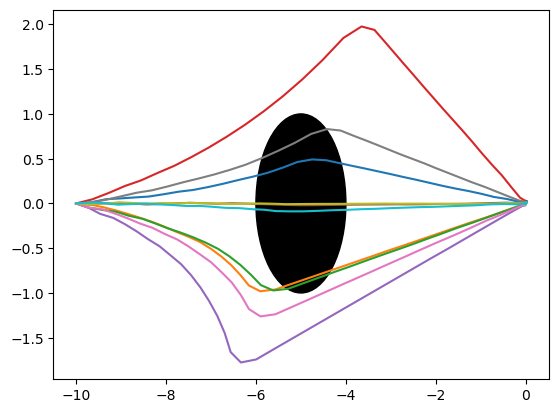

In [82]:
fig, ax = plt.subplots()
for i in range(num_traj):
    x = x_array[i]
    ax.plot(x[0,:],x[1,:])
circles = [plt.Circle(x,1,color = 'k') for x in x_o]
for circle in circles:
    ax.add_patch(circle)
fig.show()

Some remarks on the stochastic solution of this example:
- It seems like most of the trajectories are violating the constraints at some point in time. This is despite the fact that the trajectories satisfy the constraint in expectation, which can be verified by sampling a large number of trajectories and averaging over the constraint violation.
- Perturbing the position of the obstacle a little bit results again in a deterministic solution. For example, a perturbation of  of the obstacle position to $\begin{pmatrix} -5 & 0.1 \end{pmatrix}^\top$ yields a deterministic solution. This is not in general the case for stochastic solutions of our state feedback synthesis.

C:\Users\Deniss Grammel\AppData\Local\Temp\ipykernel_20652\2674195881.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


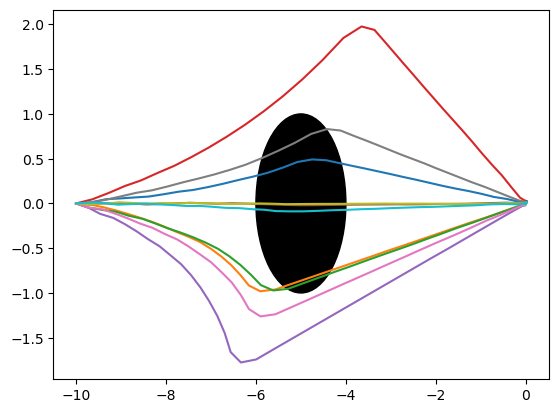

In [83]:
import tikzplotlib
fig, ax = plt.subplots()
for i in range(num_traj):
    x = x_array[i]
    ax.plot(x[0,:],x[1,:])
circle = plt.Circle([-5,0],1,color = 'k')
ax.add_patch(circle)
fig.show()
tikzplotlib.save("avoidance2.tex")

We mention possibilities to generate bounds on the probability of constraint violation.
- If the constraints are strictly convex, such that the functions representing the constraints admit lower bounds, then conservative estimates on the probability of constraint violation can be generated using concentration inequalities such as Markov's inequality.
- For general quadratic constraints (or the derivation of more accurate bounds) one can assume a family of distributions for $(x_t,u_t)$ such as Gaussian distributions. In the case of the Gaussian distribution the function
$$
    (x_t,u_t) \mapsto \begin{pmatrix}
		1\\
		x_t\\
		u_t
	\end{pmatrix}^\top H_{ti}
	\begin{pmatrix}
		1\\
		x_t\\
		u_t
	\end{pmatrix}
$$
follows a generalized $\chi^2$ distribution. In this case, the probability of constraint satisfaction can be computed as a function of $\Sigma_t$ using the probability density function of the generalized $\chi^2$ distribution. However, this might not yield a convex constraint; particularly, if the function representing the constraint is non-convex. Of course, this non-convexity would not hinder us from calculating the probability of constraint violation of any given solution.

## Example 3

It is very important to understand that satisfying individual constraints in expectation or even with high probability does not mean that these constraints are jointly satisfied.

This is explored in the present example.

To this end, we assume that the controller must avoid the whole set
$$
    \{ x\in \mathbb{R}^2 \mid -6 \leq x_1 \leq -4 \} = [-6,-4] \times \mathbb{R}
$$
This constraint can be represented as
$$
\begin{align}
    1 - (x_{1t} - 5)^2 \leq 0 && \Leftrightarrow && \begin{pmatrix}
		1\\
		x_t\\
		u_t
	\end{pmatrix}^\top H_{t2}
	\begin{pmatrix}
		1\\
		x_t\\
		u_t
	\end{pmatrix} \leq 0 \text{ with }
    H_{t2} =
    \begin{pmatrix}
        -24 & -5 & 0 & 0 & 0\\
        -5 & -1 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0\\
        0 & 0 & 0 & 0 & 0
    \end{pmatrix}.
\end{align}
$$
Notice, that this constraint makes it impossible to reach the desired target at $\begin{pmatrix} 0 & 0 \end{pmatrix}^\top$.

In [84]:
# supply function for initialization
n = 2
m = 2
N = 50

def initParameters3(N):
    R_k = np.zeros((1+n+m,1+n+m))
    for i in range(1,5): R_k[i,i] = 1
    R_N = np.zeros((1+n+m,1+n+m))
    R_N[1,1] = 1
    R_N[2,2] = 1
    Hu = np.zeros((1+n+m,1+n+m))
    Hu[0,0] = -0.1
    Hu[3,3] = 1
    Hu[4,4] = 1
    Hx = np.zeros((1+n+m,1+n+m))
    Hx[0,0] = -24
    Hx[1,1] = -1
    Hx[0,1] = -5
    Hx[1,0] = -5
    f = [np.zeros((2,1)) for k in range(N+1)]
    A = [np.array([[1,0],[0,1]]) for k in range(N+1)]
    B = [np.array([[1,0],[0,1]]) for k in range(N+1)]
    R = [R_k for k in range(N)] + [R_N]
    H = [[Hx] + [Hu] for k in range(N+1)]
    SigmaW = [0.00*np.identity(n)] + [0.00*np.identity(n) for k in range(N)]
    return (f,A,B,R,H,SigmaW,x_o)

In [85]:
xbar = np.array([[1],[-10],[0]])
Xbar = xbar@xbar.T + np.block([[np.zeros((1,1+n))],[np.zeros((n,1)),0.000001*np.identity(n)]])

f,A,B,R,H,SigmaW,x_o = initParameters3(N)

K,SigmaV,nu,Sigma = finite_horizon_stateSpace(Xbar,f,A,B,R,H,SigmaW)

print("The optimal value of the controller design problem is {}".format(nu))

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Mar 08 03:17:55 PM: Your problem has 510 variables, 154 constraints, and 0 parameters.
(CVXPY) Mar 08 03:17:55 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Mar 08 03:17:55 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Mar 08 03:17:55 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Mar 08 03:17:55 PM: Compiling problem (target solver=MOSEK).
(CVXPY) Mar 08 03:17:55 PM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffin

(CVXPY) Mar 08 03:18:01 PM:   con: 1e-06  
(CVXPY) Mar 08 03:18:01 PM:   var: 0e+00  
(CVXPY) Mar 08 03:18:01 PM:   barvar: 0e+00  
(CVXPY) Mar 08 03:18:01 PM: 
(CVXPY) Mar 08 03:18:01 PM:   Dual.    obj: -3.9638945937e+03   nrm: 1e+02    Viol.
(CVXPY) Mar 08 03:18:01 PM:   con: 0e+00  
(CVXPY) Mar 08 03:18:01 PM:   var: 2e-07  
(CVXPY) Mar 08 03:18:01 PM:   barvar: 9e-07  
(CVXPY) Mar 08 03:18:01 PM: 
-------------------------------------------------------------------------------
                                    Summary                                    
-------------------------------------------------------------------------------
(CVXPY) Mar 08 03:18:01 PM: Problem status: optimal
(CVXPY) Mar 08 03:18:01 PM: Optimal value: 1.136e+03
(CVXPY) Mar 08 03:18:01 PM: Compilation took 5.919e+00 seconds
(CVXPY) Mar 08 03:18:01 PM: Solver (including time spent in interface) took 4.980e-01 seconds
The optimal value of the controller design problem is 1136.1055082662224


In [88]:
# array for trajectories
x_array = []
u_array = []

num_traj = 10
np.random.seed(5)

for i in range(num_traj):
    x = np.zeros((n,N+1))
    u = np.zeros((m,N))
    x[:,0] = xbar[1:,0]
    for t in range(N):
        if np.trace(SigmaV[t]) > 0.0000001:
            [ew,ev] = np.linalg.eig(SigmaV[t])
            v = np.random.choice([-1,1],size = (n,1))
            v = ev@np.sqrt(ew)@v
        else:
            v = np.zeros((n,1))
        u[:,t:t+1] = K[t]@np.vstack([np.ones((1,1)),x[:,t:t+1]]) + v
        x[:,t+1] = A[t]@x[:,t] + B[t]@u[:,t]
    x_array += [x]
    u_array += [u]

C:\Users\Deniss Grammel\AppData\Local\Temp\ipykernel_20652\3717595734.py:8: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


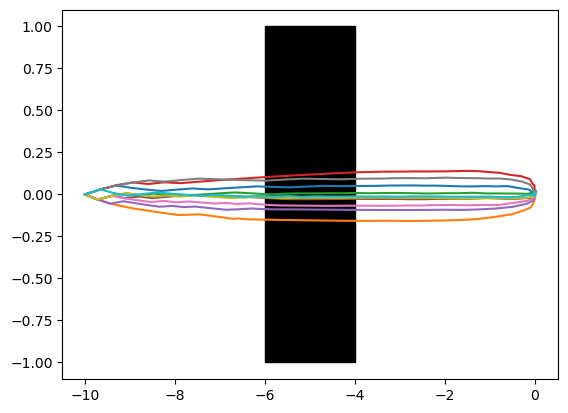

In [89]:
fig, ax = plt.subplots()
for i in range(num_traj):
    x = x_array[i]
    ax.plot(x[0,:],x[1,:])
rectangles = [plt.Rectangle([-6,-1],2,2,color = 'k') for x in x_o]
for rectangle in rectangles:
    ax.add_patch(rectangle)
fig.show()

All trajectories seem to go right through the obstacle! What happens here, reveals itself if we plot the $x_1$ trajectories over time.

C:\Users\Deniss Grammel\AppData\Local\Temp\ipykernel_20652\3548954972.py:5: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


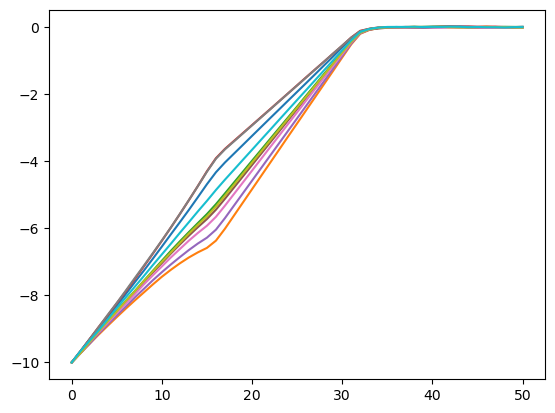

In [90]:
fig, ax = plt.subplots()
for i in range(num_traj):
    x = x_array[i]
    ax.plot(range(0,51),x[0,:])
fig.show()

As we can see, the trajectories do have some variance in the $x_1$ coordinate at the moment when they pass through the obstacle. In this fashion, they satisfy the constraint at any point in time, but nevertheless they go right through the obstacle with very high probability. Note that at every single point in time, there is a non-neglectable chance that the constraint is satisfied.

Even trying to satisfy the constraint with high probability at any point in time might not help. By generating variance in $x_1$, the controller can increase the randomness in the moment of time, when the trajectory passes through the obstacle random. This reduces the probability of constraint violation at every single moment - but constraint violation still occurs with high probability at some point in time.